# Laboratoire 3 : Machines à vecteurs de support et réseaux neuronaux
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | LEMARCHANT HUGO - LEMH03039705 * TAN ELODIE - TANE25619607 * JACQUES-SYLVAIN LECOINTRE LECJ19128301|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2018                                            |
| Groupe                | C                                                       |
| Numéro du laboratoire | 02                                                      |
| Professeur            | Prof. Hervé Lombaert                                    |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 31/10/2018                                              |

# Imports

In [73]:
import numpy as np
import cv2
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")
from time import time
from IPython.display import Markdown
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score ,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from keras import backend as K
import pandas as pd

# Extract datas

In [4]:
feature_vectors = pd.read_csv('galaxy_feature_vectors.csv', delimiter = ',', header=None)
labels = pd.read_csv('galaxy_label_data_set.csv', delimiter = ',')
X_galaxy = pd.read_csv('galaxy_feature_vectors.csv', delimiter = ',', header=None).values[:,0:-1]
Y_galaxy = pd.read_csv('galaxy_feature_vectors.csv', delimiter = ',', header=None).values[:,-1:].astype(int).flatten()
Xg_train, Xg_test, Yg_train, Yg_test = train_test_split(X_galaxy, Y_galaxy, test_size=0.20, random_state=42, stratify=Y_galaxy)

# On normalise nos features
scaler = StandardScaler()
Xg_train = scaler.fit_transform(Xg_train)
Xg_test = scaler.fit_transform(Xg_test)
# Création d'array pour stocker l'accuracy et le score f1 pour les différents nombres d'itération
accuracies = []
f1_scores = []
accuracies_npercep = []
f1_scores_npercep = []
accuracies_layers = []
f1_scores_layers = []
accuracies_learning = []
f1_scores_learning = []

# Multi Layers Perceptron

In [ ]:
batch = 100
learning_rate = 0.0005
n_epochs = 60
n_hidden_1 = 100 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
n_hidden_3 = 50 # 3rd layer number of neurons
n_hidden_4 = 2 # 4th layer number of neurons
num_input = 75
num_classes = 2

model = keras.Sequential()
model.add(layers.Dense(n_hidden_1))
model.add(layers.Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.2))

model.add(layers.Dense(n_hidden_2))
model.add(layers.Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.2))

model.add(layers.Dense(num_classes, activation='softmax'))



model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard = keras.callbacks.TensorBoard(log_dir='no_dropout/learning_1E-3', batch_size=batch, histogram_freq=0, write_graph=True, write_images=True)

model.fit(Xg_train, Yg_train, epochs=n_epochs, batch_size=batch, validation_data=(Xg_test, Yg_test),
          callbacks=[tensorboard])

test_loss, test_acc = model.evaluate(Xg_test, Yg_test)

print('Test accuracy:', test_acc)

predictions = model.predict(Xg_test)
print(predictions)
Yg_pred = model.predict_classes(Xg_test)
    
f1 = f1_score(Yg_test, Yg_pred, average='weighted')
print("f1 score: {}".format(f1))

# Support Vector Machine

In [6]:
jobs = 6
cache_size=2048
k=10
svc = SVC(cache_size=cache_size)

X_valid=Xg_train
Y_valid=Yg_train

#### recherche par grille SVM lineaire

In [7]:
def grid_search_linear(X_valid, Y_valid,k, jobs, cache_size):

    svc = SVC(cache_size=cache_size)

    param_grid_linear = {'kernel': ['linear'], 'C': [10 ** (-3), 10 ** (-1), 1, 10],'class_weight': ['balanced'],'gamma': ['scale']}

    grid_linear = GridSearchCV(svc, param_grid=param_grid_linear, cv=k, n_jobs=jobs, scoring='accuracy', verbose=4)
    grid_linear.fit(X_valid, Y_valid)

    print("LINEAR : The best hyperparameters are %s with a score of %0.2f" % (grid_linear.best_params_, grid_linear.best_score_))
    
    return grid_linear

grid_linear = grid_search_linear(X_valid, Y_valid, k, jobs, cache_size)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  6.5min finished
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  6.5min remaining:    0.0s


LINEAR : The best hyperparameters are {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'} with a score of 0.94


#### accuracy (Linear SVM)

In [20]:
df=pd.DataFrame(grid_linear.cv_results_['mean_test_score'],index=[x['C'] for x  in grid_linear.cv_results_['params']],columns=['precision'])
df.index.name='C'
df

,precision
C,
0.001,0.925181
0.100,0.940115
1.000,0.940559
10.000,0.940633


##### fiting time (Linear SVM)

In [22]:
df_lin=pd.DataFrame(grid_linear.cv_results_['mean_fit_time'],index=[x['C'] for x  in grid_linear.cv_results_['params']],columns=['temps moyen du fit'])
df_lin.index.name='C'
df_lin

,temps moyen du fit
C,
0.001,36.547501
0.100,19.690940
1.000,34.404641
10.000,90.281601


#### recherche par grille SVM non-lineaire fonction noyau RBF

In [16]:
def grid_search_rbf(X_valid, Y_valid,k, jobs, cache_size):

    svc = SVC(cache_size=cache_size)
    param_grid_rbf = {'kernel': ['rbf'], 'C': [10 ** (-3), 10 ** (-1), 1, 10], 'gamma': [10 ** (-3), 10 ** (-1), 1, 10]}
    grid_rbf = GridSearchCV(svc, param_grid=param_grid_rbf, cv=k, n_jobs=jobs, scoring='accuracy', verbose=4)

    grid_rbf.fit(X_valid, Y_valid)

    print("RBF : The best hyperparameters are %s with a score of %0.2f" % (grid_rbf.best_params_, grid_rbf.best_score_))

    return grid_rbf

grid_rbf = grid_search_rbf(X_valid, Y_valid, k, jobs, cache_size)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 32.0min
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed: 54.4min finished


RBF : The best hyperparameters are {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'} with a score of 0.95


#### accuracy (RBF)

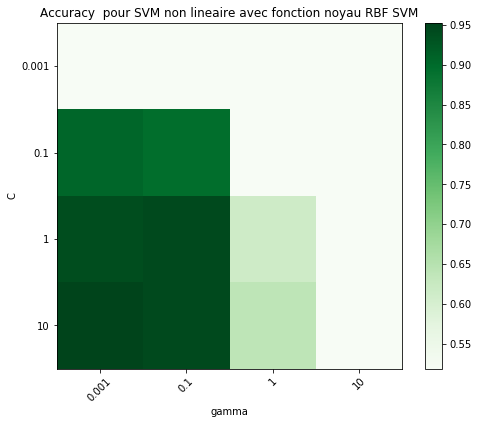

gamma     0.001     0.100     1.000     10.000
C                                             
0.001   0.519074  0.519074  0.519074  0.519074
0.100   0.905072  0.894869  0.519074  0.519074
1.000   0.938637  0.944773  0.614372  0.519074
10.000  0.952166  0.945217  0.640766  0.519074

In [69]:
gammas = [x['gamma'] for x  in grid_rbf.cv_results_['params']]
C_values=[x['C'] for x  in grid_rbf.cv_results_['params']]
fit_time = grid_rbf.cv_results_['mean_fit_time']
accuracies=grid_rbf.cv_results_['mean_test_score']

C_range=[10 ** (-3), 10 ** (-1), 1, 10]
gamma_range=[10 ** (-3), 10 ** (-1), 1, 10]

grid=grid_rbf
# We extract just the scores
scores = grid.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest',cmap='Greens' )
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Accuracy  pour SVM non lineaire avec fonction noyau RBF SVM')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

df=pd.DataFrame(list(zip(gammas,accuracies,C_values)),columns=['gamma','','C'])
df.pivot_table(columns=['gamma'],index=['C'])

#### fiting time (RBF)

In [67]:
df=pd.DataFrame(list(zip(gammas,fit_time,C_values)),columns=['gamma','','C'])
df.pivot_table(columns=['gamma'],index=['C'])

gamma       0.001       0.100       1.000       10.000
C                                                     
0.001   108.665604  105.084420  100.575474   98.379786
0.100    48.784804   47.269562  104.112872  108.335408
1.000    27.710953   47.751589  108.571365  104.675441
10.000   16.029991   42.508023   87.534814   87.072186

### Test du modele SVM C=10 Gamma=0.001 RBF

In [74]:
clf = SVC(**grid_rbf.best_params_)
clf.fit(Xg_train, Yg_train) 
Yg_pred = clf.predict(Xg_test)

acc = accuracy_score(Yg_test, Yg_pred)
f1 = f1_score(Yg_test, Yg_pred, average='weighted') 
print('accuracy : {0} F1 score: {1}'.format(acc,f1))
confusion_matrix(Yg_test,Yg_pred)

accuracy : 0.9603784742755765 F1 score: 0.9603766424673736


array([[1558,   69],
       [  65, 1690]])

In [76]:
K=10
X_normalized = scaler.fit_transform(X_galaxy)
clf = SVC(**grid_rbf.best_params_)

scores = cross_val_score(clf, X_normalized, Y_galaxy, cv=K)
print(sum(scores)/K)

0.9551680437288755


# Convolutional Neural Networks

In [1]:
print(device_lib.list_local_devices())

class NetCNN:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
 
        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(Dropout(0.2))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(Dropout(0.2))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # third set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(Dropout(0.2))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
        model.add(Dropout(0.3))
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model
    
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

with open("..\\data\\data\\csv\\galaxy\\galaxy_label_data_set.csv", 'rt') as csvFile:
    reader = csv.reader(csvFile, delimiter=",")
    # loop over the input images
    for index, row in enumerate(reader):
        if index in range(1,1000):
            # load the image, pre-process it, and store it in the data list
            file = "..\\data\\data\\images\\"+row[0]+".jpg"
            image = cv2.imread(file)
            image = cv2.resize(image, (212, 212))
            image = img_to_array(image)
            data.append(image)
            label = (0 if row[1] == 'smooth' else 1)
            labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, 
      shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

EPOCHS = 50
INIT_LR = 1e-3
BS = 25

# initialize the model
print("[INFO] compiling model...")
model = NetCNN.build(width=212, height=212, depth=3, classes=2)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

# save the model to disk
print("[INFO] serializing network...")
model.save("..\\data\\tp3\\model.hdf5")

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Smooth/Spiral")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Graphs\\3c25bs3lr.png")

## Introduction

Les Questions du notebook et celles de l'énoncé ne sont pas dans le même ordre, nous avons choisi de suivre l'ordre des questions proposé par l'énoncé.

## Question 1 
### Présentation de la méthode de validation

Nous avons opté pour une validation par hold-out. En effet toutes les autres méthodes sont gourmandes voir extrèmement gourmandes en temps de calcul pour les réseaux de neurones ou les SVM. Nous nous sommes donc contentés de séparer nos données en deux ensembles d'entraînement et de validation.
Pour la SVM, nous avons procédé à une recherche par grille des meilleurs hyper-paramètres sur une fraction de notre enssemble d'entraînement et chaque couple d'hyper-paramètres est validé par 10-fold-CV. Une fois ces paramètres optimisés nous avons entraîné le modèle avec l'ensemble d'entraînement privé des données de validations puis avons fais les tests de validation.

De manière équivalente pour les réseaux de neurones (et CNN) nous avons découpé notre ensemble en deux et avons fait nos tests d'hyper-paramètres avec ces ensemble d'entraînement et nous les comparons entre eux avec l'ensemble de validation.

## Question 2
### Description de la méthode de normalisation

#### Réseaux de neurones

Nous avons utilisé pour les réseaux de neurones la normalisation avec `StandardScaler()` de la librairie `scikitlearn`. Elle permet de transformer nos données en faisant en sorte d’avoir une moyenne de 0 et un écart type de 1, ce qui permet de d’éliminer en quelque sorte les outliers mais aussi de mettre à la même échelle l’ensemble des variables. Nous avons aussi essayé d’utiliser la fonction `normalize` de la librairie `sklearn.preprocessing`. Cependant, son utilisation n’était pas pertinente et les résultats étaient erronés car elle agit sur toute une ligne (et non pas une colonne comme `StandardScaler`). 

#### SVM

Les SVM ont pour but de maximiser une marge formée par des vecteurs de support pour séparer des classes.Cette optmisation nécessite des calculs de distances entre vecteurs ce qui implique necessairement que l'algorithme est sensible à l'échelle entre les différentes caractéristiques (features).Une normalisation similaire a celle utilisée pour le MLP a été mise en oeuvre (classe `StandardScaler` de sklearn).Cette technique est également connue sous le nom de normalisation z-score (z=x−μσ) pour annuler l'effet de la moyenne et pour que les valeurs tombent dans un intervalle fixe [0,1].

## Question 3
### Description du modèle élaboré et analyse de la phase d'entrainement

#### Structure et choix du modèle d’apprentissage
Nous avons créé deux couches cachées avec la fonction d’activation **ReLU**. Elle est beaucoup plus efficace que la fonction $tanh$, et c’est une fonction simple à dériver. De même, la fonction $Sigmoid$ prend beaucoup de temps pour converger et d’autres problèmes existent pour cette fonction comme le problème du *vanishing gradient*.  Nous n’utilisons pas $Heaviside$ car celle-ci n’est pas dérivable.

De plus, nous avons choisi d’effectuer une descente de gradient par mini-batch. Il s’agit d’un compromis entre la descente stochastique de gradient qui calcule et rétro-propage l’erreur sur pour chaque observation et l’apprentissage par batch ou . La variation de la taille des lots (batchs) permet de faire varier ce compromis. Cependant nous ne faisons pas varier la taille des lots dans ce laboratoire et l’avons fixée à 100.

A la sortie de chaque couche cachée, nous avons utilisé `BatchNormalisation()` et `Dropout()`. `BatchNormalisation()` permet au réseau de neurones de converger plus rapidement (mais pas forcément mieux) en normalisant chaque $batch$ comme avec `StandardScaler()`. En effet, lorsque nous ajustons les poids, l'echelle des données change et ne sont plus normalisées.  

`Dropout()` permet de désactiver de façon aléatoire certains neurones d’une couche. Cela permet d’éviter le sur-apprentissage et de rendre le réseau plus robuste. Nous avons donc choisi, pour chaque couche cachée, d'appliquer un taux de `dropout` de 0.2. Nous n’avons pas pris de valeurs plus élevées car cela impacte aussi le taux la précision.   

Pour finir, nous appliquons pour la dernière couche de neurones la fonction d’activation `softmax` qui permet d’obtenir en sortie les probabilités correspondant à chaque classe. 

#### Fonction de coût

Nous avons utilisé `sparse_categorical_crossentropy` pour la fonction de coût. Tout d’abord, `crossentropy` correspond bien évidemment à la $Cross-Entropy$. Elle permet d’être plus rapide contrairement à la fonction d’erreur quadratique car celle-ci est très coûteuse en temps de calcul pour une machine. De plus, `sparse_categorical_crossentropy` permet l’utilisation de la fonction sur des labels qui sont donnés dans une seule colonne (c’est à dire le numéro du label reçu), contrairement à `categorical_crossentropy` qui nous obligeait à les coder en `one-hot`. Nous n’avons pas utilisé `binary_crossentropy` pour la même raison. 

La figure ci-dessous montre le graphe tensorboad obtenue pour un MLP a deux couches cachées realisé dans le cadre de ce projet avec l'API de tensorflow directement.Les mesures de performances ont été réalisées avec keras par la suite.

On peut y voir la rétro-propagation (GradientDescent) de la sortie vers les couches precedentes et le calcul de l'erreur et de la précision entre la couche de sortie et l'entrée du réseau.

!["Tensorboard graph"](./tensorboard_mlp_2hidden_layers.png)

## Question 4
### Etude de l'évolution temporelle de l'apprentissage

Le sur-entrainement arrive généralement lorsque le processus de dsescente de gradient converge sur l’ensemble de validation converge vers un minimum local de la fonction de coût à travers les itérations (epochs). Dans nos graphiques, cette condition arrive aux alentours de 20 itérations pour un pas d'apprentissage fixé a 0.1. Cette valeur varie en fonction du pas d'apprentissage choisi (rapidité avec laquelle les poids sont mis a jour apres retro-propgation de l'erreur). Cependant, parmi nos trois ajustements de pas d'apprentissage (3, 0.1 et 1e-6), ce dernier montrait des meilleures performances pour 0.1.Cette observation  semble cohérente puisqu’un pas d'apprentissage trop élevé est moins stable et peut amener a des oscillations de la fonction de coût,alors q'un pas d'apprentissage trop faible prendra plus de temps (plus d'epochs) à converger vers un minimum local.Le nombre optimal d'epochs dans le cadre de nos conditions expérimentales semble donc autour de 20. En effet, après 20 epochs, le gain de precision pour l’ensemble de validation stagne,et la diminution du coût aussi. Nous obtenons un bon compromis qualité des predictions/temps d'entrainement avec 20 epochs.

## Question 5
### Matrice des expérimentations

#### Impact du nombre d’epochs

La généralisation du modèle est ce que l’on cherche à obtenir. Le modèle doit être capable de généraliser et donc de classifier correctement des  nouvelles données. Pour éviter le surajustement il faut donc être capable de déterminer à quel moment arrêter l'entraînement pour minimiser les erreurs de sur les données de test. Pour déterminer le nombre de cycles d’apprentissage (epochs), nous utilisons la base de validation.Cet hyperparamètre a un impact sur le sur-apprentissage et donc sur les performances générales du modele.
 
Cette interruption prématurée (early-stop) est mise en œuvre en présentant les échantillons de la base de validation à chaque cycle d'entraînement et en utilisant la fonction d’erreur pour calculer l’erreur de ce cycle. Lorsque l’erreur de la base de validation ne diminue plus ou se met à augmenter, l’apprentissage est alors interrompu prématurement.

!["NbEpochs"](Graphs/image.png)

#### Impact du nombre de couches

Sans couche cachée,la topologie ne peut séparer que des données séparables linéairement.l’ajout de couches permet de projeter les données dans un espace où les données deviennent linéairement séparables.

Avec une deux couches  cachées, les frontières de décision peuvent théoriquement être d’une complexité arbitraire.Cependant,l'ajout d'une couche supplémentaire n'est pas toujours justifié et ne se traduit pas forcément en gain significatif de performance comme le montre la figure ci-dessous.

!["NbLayers"](Graphs/image1.png)

#### Impact du nombre de perceptrons dans les couches intermédiaires

Le nombre de perceptrons dans les couches d'entrée et de sortie sont fixés et dépendent respectivement du nombre de dimensions (taille des vecteurs de caractéristiques) et du nombre de classes (2). Un perceptron implémente un hyperplan, Augmenter le nombre de perceptrons permet donc d’obtenir des régions de décision plus complexes constituées de plusieurs hyperplans.

!["NbPerceptrons"](Graphs/image3.png)

#### Impact du taux d’apprentissage (learning rate)

Le taux d’apprentissage permet de contrôler la vitesse avec laquelle les poids sont ajustés lors de la descente de gradient.La retro-propagation de l’erreur permet de converger vers un minimum local de la fonction de coût.Si le taux d’apprentissage est trop élevé,la descente de gradient pourrait ne pas converger .Inversement ,un taux d’apprentissage trop faible ralenti la vitesse de convergence de la descente de gradient et donc peut être un obstacle pour des réseaux profonds qui nécessitent beaucoup de calculs.

!["LearningRate"](Graphs/image2.png)


In [7]:
print("Avec drop-out : Loss et Accuracies")

ar = np.array([[0.2496, 0.9063, 0.1959, 0.9370], 
                  [0.2116, 0.9204, 0.1544, 0.9503], 
                  [0.1927, 0.9283, 0.1426, 0.9548], 
                  [0.1391, 0.9472, 0.1100, 0.9622],
                  [0.1231, 0.9547, 0.1086, 0.9651]])
dfepoch = pd.DataFrame(ar, 
                      index = ['avec paramètres initiaux','100 epochs', '200 epochs', '400 epochs', '600 epochs'], 
                      columns = ['loss', 'acc', 'val_loss', 'val_acc'])

print(dfepoch)

ar = np.array([[0.2153, 0.9166, 0.1691, 0.9385], 
                  [0.2213, 0.9176, 0.1586, 0.9447],
                  [0.2022, 0.9233, 0.1646, 0.9450],
                  [0.2784, 0.8918, 0.2254, 0.9199]])
dfpercep = pd.DataFrame(ar, 
                      index = ['100, 50 perceptrons', '50, 100', '200, 25', '50, 25'], 
                      columns = ['loss', 'acc', 'val_loss', 'val_acc'])
print(dfpercep)

ar = np.array([[0.2121, 0.9194, 0.1641, 0.9420], 
                  [0.2393, 0.9094, 0.1699, 0.9420], 
                  [0.2579, 0.8981, 0.1821, 0.9323]])
dflayers = pd.DataFrame(ar, 
                      index = ['3 couches cachées', '4 couches', '5 couches'], 
                      columns = ['loss', 'acc', 'val_loss', 'val_acc'])
print(dfpercep)

ar = np.array([[0.1061, 0.9607, 0.0942, 0.9663], 
                  [0.0961, 0.9649, 0.0869, 0.9687], 
                  [1.2686, 0.4354, 1.1457, 0.4243]])
dflearning = pd.DataFrame(ar, 
                      index = ['learning rate: 3', 'learning rate: 0.1', 'learning rate: 1E-6'], 
                      columns = ['loss', 'acc', 'val_loss', 'val_acc'])
print(dflearning)

print("\n\nSans drop-out : Loss, Accuracies avec F1-mesures")

ar = np.array([[0.1577, 0.9415, 0.1729, 0.9468, 0.9467770548912987, 0.9467854026859117], 
                  [0.1384, 0.9473, 0.1387, 0.95, 0.9518036663638002, 0.9517932604948441
], 
                  [0.1134, 0.9590, 0.1213, 0.95, 0.9577173269196843, 0.9577138280605294], 
                  [0.0955, 0.9650, 0.1093, 0.96, 0.9636309874755683, 0.963626117614296]])
dfepoch = pd.DataFrame(ar, 
                      index = ['avec paramètres initiaux','100 epochs', '200 epochs', '400 epochs'], 
                      columns = ['loss', 'acc', 'val_loss', 'val_acc', 'test_accuracy', 'F1 score'])

print(dfepoch)

ar = np.array([[0.1675, 0.9382, 0.1640, 0.9527, 0.9526907155529273, 0.9526907155529273], 
                  [0.1722, 0.9372, 0.1792, 0.9409, 0.9408633943354145, 0.9408263855468233],
                  [0.1579, 0.9422, 0.1629, 0.9438, 0.9438202247191011, 0.9438398613167942],
                  [0.1777, 0.9333, 0.1861, 0.9400, 0.939976345252032, 0.9399831073373335]])
dfpercep = pd.DataFrame(ar, 
                      index = ['100, 50 perceptrons', '50, 100', '200, 25', '50, 25'], 
                      columns = ['loss', 'acc', 'val_loss', 'val_acc', 'test_accuracy', 'F1 score'])
print(dfpercep)

ar = np.array([[0.1513, 0.9424, 0.1448, 0.9503, 0.9503252512248291, 0.9503152269164241], 
                  [0.1437, 0.9451, 0.1497, 0.9471, 0.9470727379190929, 0.9470733265279817], 
                  [0.1470, 0.9426, 0.1617, 0.9432, 0.9432288586635127, 0.9432071322488779]])
dflayers = pd.DataFrame(ar, 
                      index = ['3 couches cachées', '4 couches', '5 couches'], 
                      columns = ['loss', 'acc', 'val_loss', 'val_acc', 'test_accuracy', 'F1 score'])
print(dfpercep)

ar = np.array([[0.0661, 0.9752, 0.3223, 0.9119, 0.9118864576115825, 0.9116155733993972], 
                  [0.0232, 0.9905, 0.1833, 0.9539, 0.9538734475583596, 0.9538392862815737], 
                  [0.9533, 0.5129, 0.9114, 0.5269, 0.5269071556702652, 0.5270565773067073]])
dflearning = pd.DataFrame(ar, 
                      index = ['learning rate: 3', 'learning rate: 0.1', 'learning rate: 1E-6'], 
                      columns = ['loss', 'acc', 'val_loss', 'val_acc', 'test_accuracy', 'F1 score'])
print(dflearning)

Avec drop-out : Loss et Accuracies
                            loss     acc  val_loss  val_acc
avec paramètres initiaux  0.2496  0.9063    0.1959   0.9370
100 epochs                0.2116  0.9204    0.1544   0.9503
200 epochs                0.1927  0.9283    0.1426   0.9548
400 epochs                0.1391  0.9472    0.1100   0.9622
600 epochs                0.1231  0.9547    0.1086   0.9651
                       loss     acc  val_loss  val_acc
100, 50 perceptrons  0.2153  0.9166    0.1691   0.9385
50, 100              0.2213  0.9176    0.1586   0.9447
200, 25              0.2022  0.9233    0.1646   0.9450
50, 25               0.2784  0.8918    0.2254   0.9199
                       loss     acc  val_loss  val_acc
100, 50 perceptrons  0.2153  0.9166    0.1691   0.9385
50, 100              0.2213  0.9176    0.1586   0.9447
200, 25              0.2022  0.9233    0.1646   0.9450
50, 25               0.2784  0.8918    0.2254   0.9199
                       loss     acc  val_loss  val_acc


## Question 6
### Présentation de la méthode de recherche des meilleurs hyper paramètres de SVM

#### Méthode utilisée

Nous avons utilisé la méthode de recherche par grille ( `GridSearch` avec sklearn ) qui permet de tester chaque combinaison d’hyper paramètres définie et de sélectionner celle qui maximise un certain critère. Dans le cadre de ce TP, nous avons choisi le critère de précision pour sélectionner les hyper-parametres C et Gamma.Cette recherche par grille s’effectue sur un base de données de validation (sous ensemble de la base de données  d'entraînement) dédiée à cette recherche d'hyper paramètres. De plus,la recherche par gille a été réalisée avec une validation croisée ce qui permet d’avoir une plus grande certitude quant au choix du modèle SVM.

#### Résultats

Au total, 16 combinaisons d’hyper paramètres C et Gamma ont été testées pour le SVM non linéaire ce qui donne 160 itérations avec une 10-fold validation croisée.le temps d'exécution total de cette recherche par grille est de 55.5 minutes pour 13200 vecteurs de dimension 75.

Pour le SVM linéaire 4 combinaisons ont été testées pour différentes valeurs de C soit 40 itérations au total.La durée totale est de 6.5 minutes.

La normalisation des données est primordiale pour que les modèles de type SVM puissent avoir des temps d'exécution acceptables.

L'hyper-paramètre C est le compromis entre la pertinence des classifications (sur les données d'entraînement) et la taille de la marge (généralisation aux données de test).Idéalement, SVM souhaite maximiser la marge entre les hyper-plans séparateurs (formdés par les vecteurs de support) tout en ayant des classifications parfaites.

C=10 et Gamma 0.001 est la meilleure combinaison d'hyper-paramètres obtenue pour un SVM non-linéaire avec une fonction noyau de type RBF.La précision obtenue est de 0.9532 avec ces paramètres.

Pour un SVM linéaire,  le meilleur hyper-paramètre obtenu est pour C=10 avec une précision de 0.942629.Pour les autres valeurs , les précisions varient peu mais le temps d'exécution est deux a trois fois moins long lorsque C diminue (mean_fit_time retourné par gridsearch).

La plus grande valeur de C=10 a donc été retenue , ce qui assure donc peu d’erreurs de classifications sur les données d’entrainements et cette non-tolérance semble bien se généraliser sur les données de test.


#### Impact des hyperparamètres et utilité

L’approche SVM (linéaire) utilisée dans ce TP consiste à maximiser la marge entre les hyperplans qui séparent les classes formés par les vecteurs de support de ces classes. Maximiser cette marge de l’hyperplan M = 2 / ||w||  revient à minimiser la fonction de coût L(w) = ||w||^2/ 2 (critère d’optimisation quadratique) avec la contrainte que chaque échantillon de du vecteur de test soit correctement classifié.
 
Dans le cas où les échantillons sont non séparables, un hyper-paramètre C est introduit qui est le compromis de la marge poreuse (soft-margin) .La fonction de coût à minimiser devient alors sous contrainte.La tolérance aux erreurs est plus ou moins accentuée avec le paramètre C. Plus C est grand plus la tolérance aux mauvaises classifications est basse,ce qui implique une plus petite marge.
 
Dans le cas ou les classes ne sont pas séparables linéairement,les vecteurs d’entrée sont projetés dans un espace de plus grande dimension avec une transformation non linéaire à l’aide d’une fonction noyau de type RBF qui ont des propriétés permettant de simplifier le calcul (astuce du noyau).
 
L‘apprentissage devient un problème d’optimisation quadratique sous contraintes (avec méthode Lagrangienne et un multiplicateur Lagrangien) ce qui rend ces modèles sensibles a la taille des données.
 
Dan ce cas il y  a deux hyperparamètres C et Gamma.Gamma contrôle la variance des fonctions noyaux (inverse de sigma) Plus gamma augmente plus les rayons autour des de chaque points seront resserrés ce qui entraîne du sur-apprentissage.A l’inverse , un Gamma trop petit donnera une mauvaise généralisation et un sous-apprentissage.

## Question 7
### Discussion de l'impact de la taille des données

Pour des primitives intéressantes, une taille plus importante de données est bien sûr bénéfique car cela nous permettra de mieux généraliser notre problème, cependant cela va rallonger le temps d'entraînement de notre algorithme.

Pour les SVM , la complexité de l’algorithme est quadratique avec la taille des données : O(nombre de caractéristiques x nombre d’observation^2), augmenter la taille des données pourrait rendre l’algorithme trop coûteux en mémoire et en CPU.Pour ce faire les prédispositions suivantes ont été prises compte-tenu de la taille des données :

- L'utilisation appropriée du cache (2GB)
- Normalisation des données 

## Question 8
### Formulation des recommandations

## Question 9
### Améliorations possibles

La préparation des données pourrait permmettre une amélioration des performances en réduisant le bruit et les données aberrantes.

Effectuer une meilleure normalisation avant d'entraîner les classifieurs comme une mise a l'échelle Min-Max.

Nous pourrions aussi faire une réduction de dimensionnalité pour le SVM puisque la complexité de l’algorithme dépend directement du nombre de features donc cela pourrait être une piste d’amélioration pour nos classificateurs.


## Question Bonus

Le réseau de neurones convolutif est un réseau de neurones classique à la différence que les neurones de la couche de convolution partagent le même poids, qui est en fait une fenêtre de convolution. C’est à dire dans notre cas une matrice 5x5 de poids. De cette manière chaque neurone correspond à un déplacement de la matrice sur l’image (un déplacement de la fenêtre de convolution). L’objectif pour ces couches est de trouver les poids de cette matrice tels qu’ils minimisent la fonction de coût (ici binary_crossentropy). Ensuite après cette couche de convolution, nous faisons un maxPooling qui revient à considérer un cadre de 2x2 neurones et de synthétiser cette fenêtre en la valeur maximale présente dans cette fenêtre (on utilise le max plutôt que la moyenne car la littérature montre que le maximum décrit mieux la fenêtre que la moyenne).

Nos de convolutions suivies de maxPooling activées avec ReLU, une couche dense (ou fully-connected) avec la même fonction d’activation ReLU et enfin une couche de décision de deux neurones avec une activation softMax pour traduire les résultats en probabilités.

Nous avons de plus ajouté un dropout sur nos différentes couches (20% et 30% pour les couches de convolution et la couche dense) pour empêcher notre réseau de faire du sur-apprentissage. En effet avec ces extinction de neurones, on entraîne virtuellement un forêt de réseaux tels que le réseau complet une fois entraîné sera la décision moyenne de cette forêt.
Pour ce classifieur, nous avions accès à trois hyper-paramètres : le taux d’apprentissage, la taille du mini batch et le nombre de couches de convolutions.

Pour la taille du mini batch, nous ne pouvons pas faire varier énormément car si celle ci devient trop importante le batch ne peut plus être chargé en mémoire. Nous avons donc testé avec des tailles de 25 et 10. Le taux d'apprentissage initial a été paramétré à 1e-1, 1e-3 et 1e-5. Nous avons comparé d’un autre côté l’apprentissage via 2 et 3 couches de convolution.

Ci dessous la comparaison entre les deux tailles de mini batch:

__Batch size = 10__
!["Batch size = 10"](Graphs/2c10bs3lr.png)
__Batch size = 25__
!["Batch size = 25"](Graphs/2c25bs3lr.png)

Ci dessous la comparaison entre deux et trois couches convolutives:

__3 couches de convolution__
!["3 couches de convolution"](Graphs/3c25bs3lr.png)
__2 couches de convolution__
!["2 couches de convolution"](Graphs/2c25bs3lr.png)

Ci dessous la comparaison entre 3 valeurs de learning rate:

__Learning rate = 1e-1__
!["Learning rate = 1e-1"](Graphs/2c25bs1lr.png)
__Learning rate = 1e-5__
!["Learning rate = 1e-5"](Graphs/2c25bs5lr.png)
__Learning rate = 1e-3__
!["Learning rate = 1e-3"](Graphs/2c25bs3lr.png)

On observe que le batch size de 10 permet un apprentissage plus constant, les écarts entre validation et entraînement sont moins importants. On observe aussi des meilleurs résultats sur les 10 premières itérations. Les mêmes effets sont visibles à l’ajout d’une troisième couche de convolution.
Le learning rate lui à des effets bien plus visibles, un learning rate très grand fait diverger instantanément le réseau et le gradient devient très grand. Le learning rate de 1e-5 lui donne une courbe très lisse avec une précision égale au terme des 50 itérations.

## Conclusion

## Bibliographie